In [43]:
#Dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from pycaret.nlp import *
from pycaret.classification import *

from sklearn.feature_extraction.text import CountVectorizer

In [44]:
df = pd.read_csv('data.csv')

In [45]:
#Convert a collection of text documents to a matrix of token counts.
#implements both tokenization and occurrence counting in a single class:
tf_vectorizer = CountVectorizer()

In [46]:
features = tf_vectorizer.fit_transform(df['summary'].apply(lambda features : np.str_(features)))

In [47]:
features_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())

In [ ]:
print("Vocabulary: ", tf_vectorizer.vocabulary_)

In [48]:
features_df.head(5)

,00,101,14,1864,1930s,1st,2003,2008,21th,2weeks,...,yay,yet,yiddish,york,you,young,your,yourself,yuk,zardoz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df = pd.concat([features_df,df['actual_ratings']],axis=1)

In [50]:
df.head(5)

,00,101,14,1864,1930s,1st,2003,2008,21th,2weeks,...,yet,yiddish,york,you,young,your,yourself,yuk,zardoz,actual_ratings
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [52]:
new_df = df.drop(df.index[df['actual_ratings'] == 3])

In [53]:
new_df.loc[(df['actual_ratings'] == 4) | (new_df['actual_ratings'] == 5), 'derived_ratings'] = 'positive'
new_df.loc[(df['actual_ratings'] == 1) | (new_df['actual_ratings'] == 2), 'derived_ratings'] = 'negative'
new_df.drop(['actual_ratings'], axis=1, inplace=True)


In [15]:
#Shuffle your dataset 
new_shuffle_df = new_df.sample(frac=1)

# Define a size for your train set 
new_train_size = int(0.75 * len(new_df))

# Split your dataset 
new_train_df = new_shuffle_df[:new_train_size]
new_test_df  = new_shuffle_df[new_train_size:]

In [21]:
numerical_features = list(features_df.columns)
new_clf = setup(data = new_train_df, target = 'derived_ratings',numeric_features=numerical_features, use_gpu=True)


#new_clf=setup(data=new_train_df,target='derived_ratings')

,Description,Value
0,session_id,1419
1,Target,derived_ratings
2,Target Type,Binary
3,Label Encoded,"negative: 0, positive: 1"
4,Original Data,"(626, 1298)"
5,Missing Values,False
6,Numeric Features,1297
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8699,0.0000,0.9811,0.8794,0.9271,0.3202,0.3964,0.0460
svm,SVM - Linear Kernel,0.8654,0.0000,0.9649,0.8860,0.9236,0.3549,0.3914,0.0620
et,Extra Trees Classifier,0.8653,0.7311,0.9757,0.8786,0.9245,0.3135,0.3649,1.3240
dt,Decision Tree Classifier,0.8631,0.6813,0.9459,0.8982,0.9210,0.4036,0.4222,0.0940
rf,Random Forest Classifier,0.8631,0.7373,0.9919,0.8658,0.9245,0.2213,0.2983,1.3440
ada,Ada Boost Classifier,0.8630,0.7396,0.9730,0.8787,0.9231,0.2982,0.3550,0.3200
lr,Logistic Regression,0.8540,0.8399,0.9919,0.8581,0.9199,0.1257,0.1503,0.0910
gbc,Gradient Boosting Classifier,0.8539,0.6788,0.9784,0.8662,0.9186,0.2073,0.2643,0.5110
lda,Linear Discriminant Analysis,0.8516,0.6402,0.9486,0.8842,0.9150,0.3292,0.3554,0.3040
knn,K Neighbors Classifier,0.8448,0.6669,0.9892,0.8514,0.9150,0.0636,0.0801,0.9840


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1419,
                solver='auto', tol=0.001)

In [24]:
K_FOLDS = 5
top_model = compare_models(sort='F1',
                           fold=K_FOLDS,
                           n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8745,0.7383,0.9865,0.8798,0.9300,0.3413,0.4074,1.5500
ridge,Ridge Classifier,0.8699,0.0000,0.9784,0.8811,0.9270,0.3384,0.3952,0.0700
gbc,Gradient Boosting Classifier,0.8676,0.7040,0.9811,0.8768,0.9260,0.3133,0.3696,0.5760
rf,Random Forest Classifier,0.8653,0.7574,0.9946,0.8662,0.9258,0.2275,0.3318,1.3440
dt,Decision Tree Classifier,0.8631,0.6564,0.9568,0.8898,0.9219,0.3715,0.3903,0.0860
lr,Logistic Regression,0.8540,0.8430,0.9919,0.8577,0.9198,0.1428,0.2107,0.0800
lda,Linear Discriminant Analysis,0.8562,0.6546,0.9514,0.8869,0.9178,0.3450,0.3628,0.2860
lightgbm,Light Gradient Boosting Machine,0.8448,0.6182,1.0000,0.8448,0.9159,0.0000,0.0000,0.1460
dummy,Dummy Classifier,0.8448,0.5000,1.0000,0.8448,0.9159,0.0000,0.0000,0.0120
ada,Ada Boost Classifier,0.8494,0.7414,0.9595,0.8749,0.9148,0.2582,0.2906,0.3640


In [25]:
tuned_model = tune_model(top_model[1], optimize='F1',
                         choose_better=True, fold=K_FOLDS);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8977,0.0000,1.0000,0.8916,0.9427,0.4830,0.5643
1,0.8409,0.0000,0.9865,0.8488,0.9125,0.0888,0.1421
2,0.8636,0.0000,0.9865,0.8690,0.9241,0.2826,0.3525
3,0.8851,0.0000,0.9865,0.8902,0.9359,0.3942,0.4506
4,0.8736,0.0000,1.0000,0.8706,0.9308,0.2362,0.3660
Mean,0.8722,0.0000,0.9919,0.8741,0.9292,0.2970,0.3751
Std,0.0193,0.0000,0.0066,0.0158,0.0103,0.1351,0.1388


In [26]:
bagged_model = ensemble_model(tuned_model, optimize="F1",
                              fold=K_FOLDS) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8864,0.7095,1.0000,0.8810,0.9367,0.4022,0.5017
1,0.8409,0.5232,0.9865,0.8488,0.9125,0.0888,0.1421
2,0.8636,0.6718,0.9865,0.8690,0.9241,0.2826,0.3525
3,0.8736,0.6429,0.9865,0.8795,0.9299,0.3040,0.3698
4,0.8736,0.6819,1.0000,0.8706,0.9308,0.2362,0.3660
Mean,0.8676,0.6459,0.9919,0.8698,0.9268,0.2628,0.3464
Std,0.0152,0.0649,0.0066,0.0115,0.0082,0.1025,0.1156


In [30]:
best_model = bagged_model
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8936,0.6357,0.9880,0.9011,0.9425,0.2480,0.3105


In [31]:
plot_model(best_model, plot="parameter")

,Parameters
base_estimator,"RidgeClassifier(alpha=0.73, class_weight=None,..."
bootstrap,True
bootstrap_features,False
max_features,1.0
max_samples,1.0
n_estimators,10
n_jobs,1
oob_score,False
random_state,1419
verbose,0


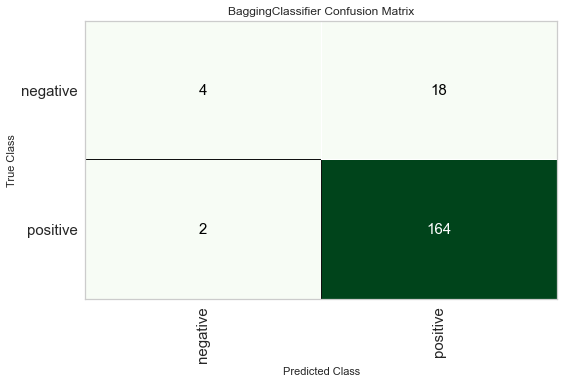

In [32]:
plot_model(best_model, plot="confusion_matrix")

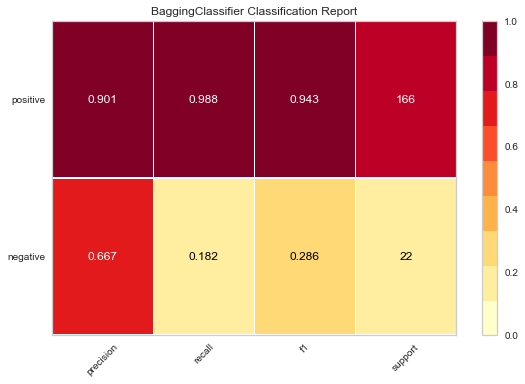

In [33]:
plot_model(best_model, plot="class_report")

In [34]:
final_model = finalize_model(best_model)

In [35]:
predict_unseen = predict_model(final_model, data=new_test_df);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0,0.6155,0,0,0,0,0


In [36]:
predict_unseen

,00,101,14,1864,1930s,1st,2003,2008,21th,2weeks,...,york,you,young,your,yourself,yuk,zardoz,derived_ratings,Label,Score
886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
951,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
290,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,positive,positive,1.0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,negative,positive,0.7
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,1.0


In [38]:
save_model(final_model,"deployment_04072022")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['00', '101', '14',
                                                           '1864', '1930s',
                                                           '1st', '2003', '2008',
                                                           '21th', '2weeks',
                                                           '30', '592', '85',
                                                           '99', 'ab',
                                                           'abagnale',
                                                           'abbreviated',
                                                           'about', 'above',
